In [1]:
import numpy as np
import itertools
from Bio.PDB import *
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from mpl_toolkits import mplot3d

In [1]:
%matplotlib notebook

In [5]:
# размер рисунков
plt.rcParams['figure.figsize'] = [12, 6]

In [6]:
pdb_file = 'data/1j1d_2.pdb'

In [7]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = list(colors.values())

In [8]:
def get_bonds(chain_a, chain_b):
    res = []
    for residue_a in chain_a:
        for residue_b in chain_b:
            for atom_a in residue_a:
                for atom_b in residue_b:
                    if atom_a.get_name() in ['O', 'N'] and atom_b.get_name() in ['O', 'N'] and atom_a.get_name() != atom_b.get_name():
                        res.append((atom_a, atom_b, atom_a - atom_b))
    return res

In [9]:
parser = PDBParser()
structure = parser.get_structure('structure_name', pdb_file)

c:\users\komar\pycharmprojects\proto_venv2\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6430.
  warnings.warn(
c:\users\komar\pycharmprojects\proto_venv2\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6433.
  warnings.warn(
c:\users\komar\pycharmprojects\proto_venv2\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6436.
  warnings.warn(
c:\users\komar\pycharmprojects\proto_venv2\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6454.
  warnings.warn(
c:\users\komar\pycharmprojects\proto_venv2\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6475.
  warnings.warn(
c:\users\komar\pycharmprojects\proto_venv2\lib\site-packages\Bio\PDB\StructureBuilder.py:8

In [10]:
# получаем все цепочки
chains = dict()
for model in structure:
    for chain in model:
        chains[chain.id] = chain

In [11]:
# получаем координаты alpha-углеродов
ppb = PPBuilder()
v = dict()
for chain_id in chains:
    vectors = []
    pp = ppb.build_peptides(chains[chain_id])
    for el in pp:
        alpha_carbons = el.get_ca_list()
        for atom in alpha_carbons:
            residue = atom.get_parent()
            residue_id = residue.get_full_id()
            resseq = residue_id[3][1]
            vectors.append([*atom.get_vector(), resseq])
    vectors = np.array(vectors)
    v[chain_id] = vectors

In [12]:
# проходим по всем парам цепочек
bonds = []
chains_ids = sorted(chains.keys())
for chain_one, chain_two in itertools.combinations(chains_ids, 2):
    res = get_bonds(chains[chain_one], chains[chain_two])
    bonds.extend(res)

In [13]:
# получаем расстояния
distances = [x[2] for x in bonds]

In [14]:
def visualize(thr, desired_chains=None):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if not desired_chains:
        filtered_chains = chains
        desired_chains = chains.keys()
    else:
        filtered_chains = {key:value for key, value in chains.items() if key in desired_chains}

    # plot chains
    for idx, chain_id in enumerate(sorted(filtered_chains)):
        vect = v[chain_id]
        res = []
        prev = vect[0, 3]
        cur = [vect[0, :]]
        for el in vect[1:, :]:
            if el[3] - prev > 1:
                cur = np.array(cur)
                res.append(cur)
                cur = [el]
            else:
                cur.append(el)
            prev = el[3]
        cur = np.array(cur)
        res.append(cur)

        for el in res:
            ax.plot3D(el[:, 0], el[:, 1], el[:, 2], color=colors[idx], linewidth=0.2)
            ax.scatter3D(vect[:, 0], vect[:, 1], vect[:, 2], color=colors[idx], s=2)
            
    # filter by distance
    indices = np.argwhere(np.array(distances) <= 4)
    filtered_bonds = [bonds[idx[0]] for idx in indices]
            
    # plot bonds
    for el in filtered_bonds:
        atom_a, atom_b, dist = el
        if atom_a.parent.parent.id in desired_chains and atom_b.parent.parent.id in desired_chains:  
            vect = np.array([[*atom_a.get_vector()], [*atom_b.get_vector()]])
            ax.plot3D(vect[:, 0], vect[:, 1], vect[:, 2], color='k', linewidth=2)

Минимальное расстояние, порог должен быть выше него

In [15]:
np.min(distances)

2.7996156

In [2]:
visualize(2.5)

NameError: name 'visualize' is not defined

In [17]:
chains.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F'])

<IPython.core.display.Javascript object>


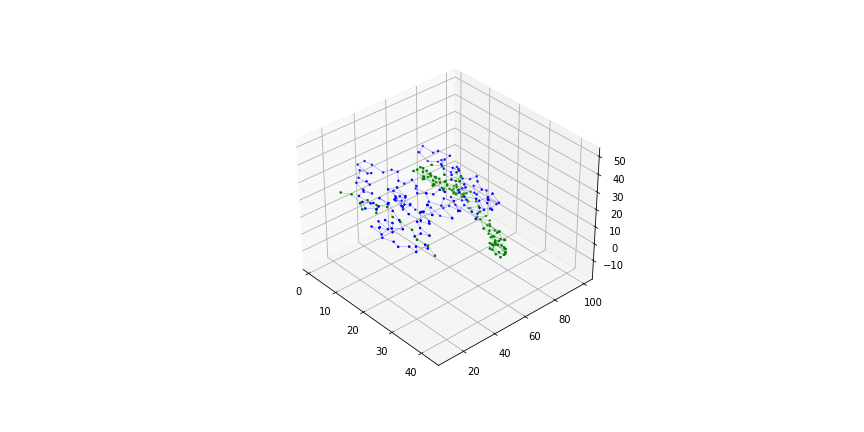

In [18]:
visualize(2.5, ['A', 'C'])